##### Ordinary differential equations
ODE: Defined by a vector field $u_t(X_t): \mathbb{R}^d\times[0,1] \rightarrow \mathbb{R}^d,  (x,t)\rightarrow u_t(x)$, which imposes a condition on it's solution.

Trajectory: solution to an ODE from a given initial condition i.e. solution to the equation

$$
\begin{aligned}
&\frac{d}{dt}X_t=u_t(X_t),
\\
&X_0=x_0
\end{aligned}
$$

Flow: collection of trajectories from multiple initial conditions, i.e. for an initial condition and time, the flow gives the value of the trajectory from that initial point at the given time.

$$
\psi: \mathbb{R}^d\times[0,1]\rightarrow\mathbb{R}^d,  (X_0,t)\rightarrow\psi_t(X_0)
$$



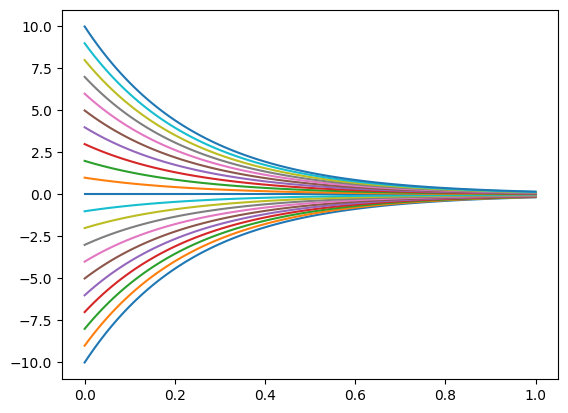

In [22]:
# Euler method simulation of a linear ODE: x' = -ax, a > 0 e.g. a = 4, with flow x(t) = x0*exp(-at)

import jax
import jax.numpy as jnp
from jax import grad, jit

# Define the ODE vector field fn
def u(x, t):
  return -4*x

x0s = jnp.arange(-10., 11., 1.)

n_steps = 100
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)

def euler_step(x, t, h):
  x_th = x + h*u(x, t)
  return x_th, x_th

def trajectory(x0):
  return jax.lax.scan(lambda x, t: euler_step(x, t, h), x0, ts[1:])[1]

flow = jax.lax.concatenate([
  x0s[:, None],
  jax.vmap(trajectory)(x0s)
], 1)

# plot the flow

import matplotlib.pyplot as plt

plt.plot(ts, flow.T)
plt.show()


(101, 21)


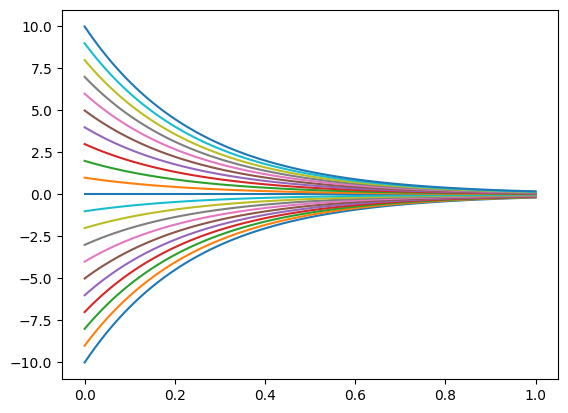

In [11]:
def soln(t, x0):
  return x0*jnp.exp(-4*t)

flow = jax.vmap(soln, in_axes=(0, None))(ts, x0s)
print(flow.shape)

plt.plot(ts, flow)
plt.show()

##### Flow model

Generative model that samples from the data distribution $p_{data}$ by using the simulation of an ODE to transform a simple distribution $p_{init}$ (e.g. Gaussian) to the complex distribution $p_{data}$. Model is described by the ODE below, where the vector field $u_t^{\theta}(X_t)$ is a neural network with parameters $\theta$.

$$
\begin{aligned}
&X_0\sim p_{init}
\\
&\frac{d}{dt}X_t=u_t^{\theta}(X_t),
\end{aligned}
$$

Simulating the ODE gives the flow $\psi_1^{\theta}$ induced by the vector field $u_t^{\theta}$. The endpoint $X_1\sim p_{data} \Leftrightarrow \psi_1^{\theta}(X_0)\sim p_{data}$.

##### Stochastic differential equations
SDE: Defined by a vector field $u_t(X_t): \mathbb{R}^d\times[0,1] \rightarrow \mathbb{R}^d,  (x,t)\rightarrow u_t(x)$, and a diffusion coefficient $\sigma_t: [0,1]\rightarrow\mathbb{R}_{\ge 0}$

Solution to SDE from a given initial condition is a stochastic process, a collection of random variables indexed by time $(X_t)_{0\ge t\ge 1}$ i.e. a collection (or probabilities) of random trajectories that are solutions to the equation,

$$
\begin{aligned}
&dX_t=u_t(X_t)dt+\sigma_t dW_t,
\\
&X_0=x_0
\end{aligned}
$$

$dW_t$ are infinitesimal Brownian motion increments. Brownian motion/Wiener process is a stochastic process $(W_t)_{0\ge t\ge 1}$ such that: $W_0=0$, the trajectories $t\rightarrow W_t$ are continuous and have Normal, independent increments, $W_{t+h}-W_t\sim \mathcal{N}(0,hI)$.

SDEs do not have a flow map $\psi_t$ since $X_t$ is stochastic and not fully determined by $X_0\sim p_{init}$.



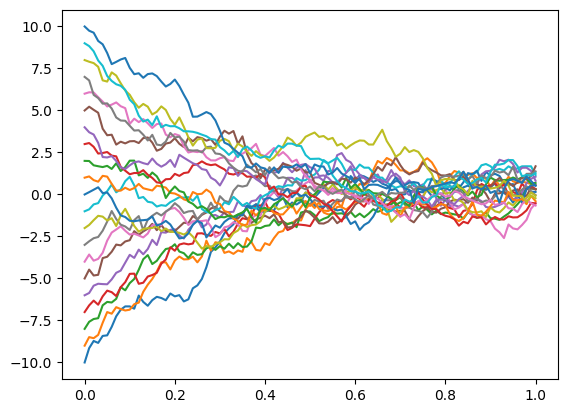

In [24]:
# Simulation of SDE (Ornstein-Uhlenbeck process: dX_t = -aX_t dt + sdW_t, a > 0) using Euler-Maruyama method

rng_key = jax.random.PRNGKey(0)

# TODO: sample random increments e from a normal distribution outside the step function

es_all = jax.random.normal(rng_key, (x0s.shape[0], n_steps))

s = 3.0

def euler_maruyama_step(x, te, h, s):
  t, e = te
  dw = jnp.sqrt(h)*e
  x_th = x - 4*x*h + s*dw
  return x_th, x_th

def trajectory(x0, es):
  return jax.lax.scan(lambda x, te: euler_maruyama_step(x, te, h, s), x0, (ts[1:], es))[1]

flow = jax.lax.concatenate([
  x0s[:, None],
  jax.vmap(trajectory)(x0s, es_all)
], 1)

plt.plot(ts, flow.T)
plt.show()

##### Diffusion model

Generative model that samples from the data distribution $p_{data}$ by using the simulation of an SDE with initial conditions sampled from a simple distribution $X_0\sim p_{init}$. Model is described by the SDE below, where the vector field $u_t^{\theta}(X_t)$ is an NN, and the diffusion coeff $\sigma_t$ is typically fixed (but can also be parameterized).

$$
\begin{aligned}
&X_0\sim p_{init}
\\
&dX_t=u_t^{\theta}(X_t)dt + \sigma_t dW_t,
\end{aligned}
$$

Simulating the SDE gives the endpoint (a realization of a random variable) $X_1\sim p_{data}$.